# **Assessment 3. Project Findings, Analysis and Sustainability**


---


Alina Stepanova A00107097

Mujahed Ali Mohammed A00128493

Hussain Uddin Syed A00145530

---


Masters of Information Technology (Advanced)

Masters of Software Engineering (Artificial Intelligence, Advanced)

Masters of Information Technology (Advanced)

---
Torrens University Australia

---


ITA602: Advanced Information Technology – Work Integrated Learning

---


Learning Facilitator: Bhagwan Das

---


August 20, 2025

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE


# **Data Preprocessing**

In [33]:
# Load your dataset
#df = pd.read_csv("C:/Users/SPECTRE/Desktop/phishing.csv")
df = pd.read_csv("/content/phishing.csv")

# Drop Index column if present
if 'Index' in df.columns:
    df.drop('Index', axis=1, inplace=True)

# Separate features and target
X = df.drop('class', axis=1)
y = df['class']  # -1 = Legitimate, 1 = Phishing

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle class imbalance
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Standardise data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)


In [34]:
#print(df.describe)

In [35]:
df = pd.read_csv("/content/phishing.csv")

# Drop Index if exists
if 'Index' in df.columns:
    df = df.drop('Index', axis=1)

X = df.drop('class', axis=1)
y = df['class']

# Convert labels: -1 (legit) → 0, 1 (phishing) → 1
y = y.replace(-1, 0)

# Continue with train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle imbalance
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Feature scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# **Model training and evaluating**

In [36]:
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier()
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train_res)
    y_pred = model.predict(X_test_scaled)
    report = classification_report(y_test, y_pred, output_dict=True)
    f1 = report['weighted avg']['f1-score']
    results[name] = f1
    print(f"{name} F1-score: {f1:.4f}")

Decision Tree F1-score: 0.9598
Random Forest F1-score: 0.9674
XGBoost F1-score: 0.9688


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [05:11:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


SVM F1-score: 0.9592
KNN F1-score: 0.9430


# **Visualisation**


Best model: XGBoost with F1-score: 0.9688


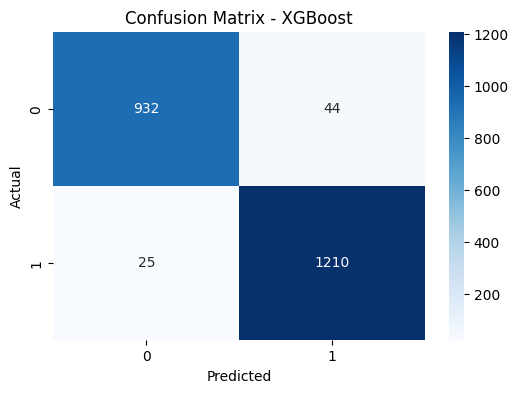

In [37]:
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
print(f"\nBest model: {best_model_name} with F1-score: {results[best_model_name]:.4f}")

# Predict again
y_pred_best = best_model.predict(X_test_scaled)

# Confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


**XGBoost** model achieved the best performance with the **highest F1-score** - 0.969.

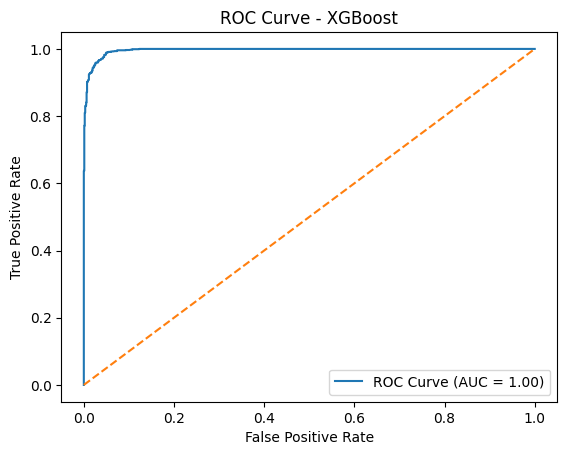

In [38]:
y_probs = best_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_model_name}')
plt.legend(loc='lower right')
plt.show()

 97%|=================== | 2134/2211 [00:13<00:00]       

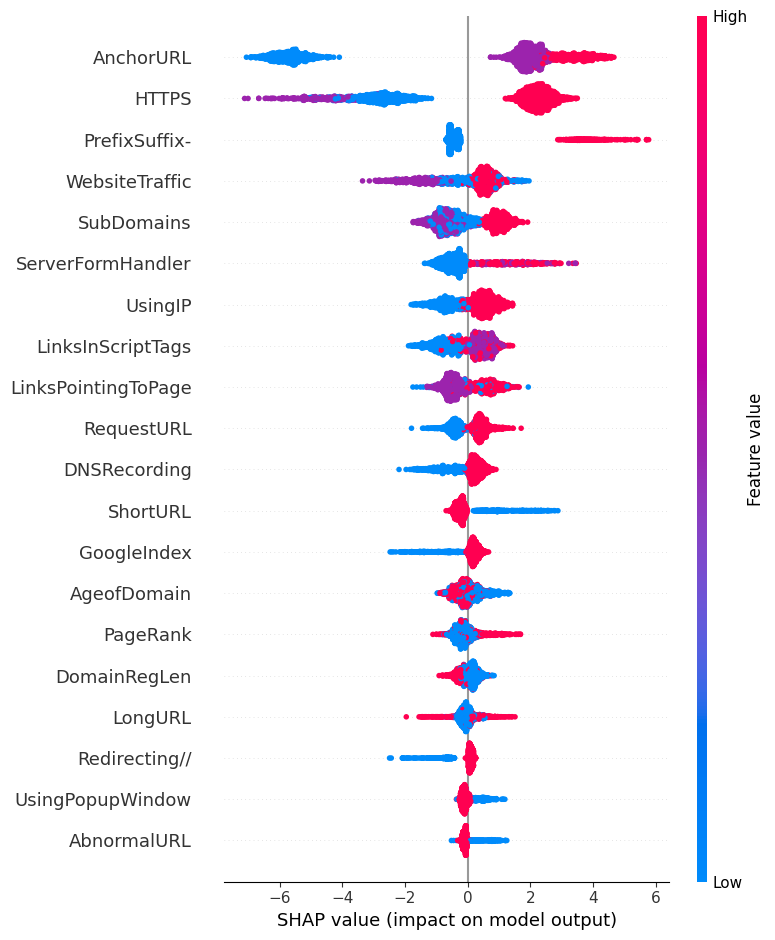

In [39]:
if best_model_name in ['Random Forest', 'Decision Tree', 'XGBoost']:
    import shap
    explainer = shap.Explainer(best_model, X_test_scaled)
    shap_values = explainer(X_test_scaled)
    shap.summary_plot(shap_values, X_test, show=True)

/tmp/ipython-input-182743856.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(results.keys()), y=list(results.values()), palette = "Blues_d", edgecolor = "black")


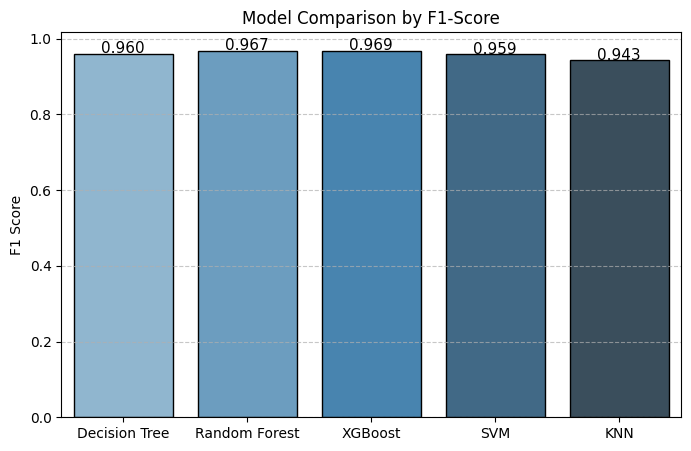

In [40]:
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=list(results.keys()), y=list(results.values()), palette = "Blues_d", edgecolor = "black")
plt.title("Model Comparison by F1-Score")
plt.ylabel("F1 Score")
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)

for bar in ax.patches:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2,
            height + 0.002,
            f"{height:.3f}",
            ha = 'center',
            fontsize = 11) # Forms the spacing of all elements to not overlap

plt.show()